# ID The Composer Algorithm
##A Deep Learning Neural Network for Composer Identification

###Overview & Goals
This code is designed to ingest music files to train deep learning models in order to identify the composer based on the music alone. The primary objective is to develp a deep learnign model that can predict the composer of a given musical score accurately.

The project aims to accomplish this objective by using two deep learning techniques: Long Short-Term Memory (LSTM) and Convolutional Neural Network (CNN).

This project is part of the Master's In Applied Artificial Intelligence program at the University of San Diego.

###Methodology for this Project
1. Data Collection (data provided)
2. Data Pre-processing: Convert the musical scores into a format suitable for deep learning models. This involves converting the musical scores into MIDI files and applying data augmentation techniques.
3. Feature Extraction: Extract features from the MIDI files, such as notes, chords, and tempo, using music analysis tools.
4. Model Building: Develop a deep learning model using LSTM and CNN architectures to classify the musical scores according to the composer.
5. Model Training: Train the deep learning model using the pre-processed and feature-extracted data.
6. Model Evaluation: Evaluate the performance of the deep learning model using accuracy, precision, and recall metrics.
7. Model Optimization: Optimize the deep learning model by fine-tuning hyperparameters.




##Data Pre-Processing

In [1]:
!pip install pretty_midi
#!pip install kagglehub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 8.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 5.0 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592286 sha256=bfee507317fc3b538799e41f10fe8354464d8514f561b4ee6ac99ddb34f2433b
  Stored in directory: /root/.cache/pip/wheels/e6/95/ac/15ceaeb2823b04d8e638fd1495357adb8d26c00ccac9d7782e
Successfully built pretty_midi


In [2]:
# Import Key Libraries
import os
import zipfile
from zipfile import ZipFile
import warnings
import pretty_midi
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import pretty_midi as pm
import kagglehub as kagglehub # Wire to kaggle?
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
'''
#path = kagglehub.dataset_download("blanderbuss/midi-classic-music")
#print("Path to dataset files:", path)

In [3]:
# Connect to dataset in Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
#Define filepaths
zip_path = '/content/drive/My Drive/AAI-511-Team7ProjectFolder/Composer_Data/Composer_Dataset.zip'
extract_base_dir = '/content/drive/My Drive/AAI-511-Team7ProjectFolder/Composer_Data'

#Code to extract zip file
#with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#    zip_ref.extractall(extract_base_dir)

In [6]:
base_path = os.path.join(extract_base_dir, 'Composer_Dataset/NN_midi_files_extended')
# List the immediate subdirectories (should be the splits: train, dev, test)
splits = next(os.walk(base_path))[1]  # This gets directory names in NN_midi_files_extended

unique_composers = set()

for split in splits:
    split_path = os.path.join(base_path, split)
    # List immediate subfolders in each split, these should be composer names
    composers = next(os.walk(split_path))[1]
    unique_composers.update(composers)

# Print unique composer names collected from all splits
for composer in sorted(unique_composers):
    print(composer)

bach
bartok
byrd
chopin
handel
hummel
mendelssohn
mozart
schumann


In [8]:
data_dir = os.path.join(extract_base_dir, 'Composer_Dataset/NN_midi_files_extended')
splits = ['test', 'train', 'dev']
composers = ['bach', 'handel', 'chopin', 'mozart'] #Beethoven is not in this dataset, substituted for another composer
supported_ext = ('.mid', '.midi')

In [9]:
def get_midi_file_paths_by_split_and_composer(data_dir, splits, composers, supported_ext):
    """
    Collects all MIDI file paths for specified splits and composers.
    Returns a nested dictionary: {split: {composer: [file_paths]}}
    Prints a warning if a composer directory is not found.
    """
    midi_files = {split: {composer: [] for composer in composers} for split in splits}
    for split in splits:
        for composer in composers:
            composer_dir = os.path.join(data_dir, split, composer)
            if os.path.exists(composer_dir):
                midi_files[split][composer] = [
                    os.path.join(composer_dir, f)
                    for f in os.listdir(composer_dir)
                    if f.lower().endswith(supported_ext)
                ]
            else:
                print(f"Composer directory not found: {composer_dir}")
    return midi_files

In [10]:
# Gather paths grouped by composer + split
midi_files = get_midi_file_paths_by_split_and_composer(data_dir, splits, composers, supported_ext)

In [11]:
#Print example file paths for one composer
print("Train files:")
for f in midi_files['train']['bach'][:5]:
    print(f)

print("\nDev files:")
for f in midi_files['dev']['bach'][:5]:
    print(f)

print("\nTest files:")
for f in midi_files['test']['bach'][:5]:
    print(f)

Train files:
/content/drive/My Drive/AAI-511-Team7ProjectFolder/Composer_Data/Composer_Dataset/NN_midi_files_extended/train/bach/bach368.mid
/content/drive/My Drive/AAI-511-Team7ProjectFolder/Composer_Data/Composer_Dataset/NN_midi_files_extended/train/bach/bach355.mid
/content/drive/My Drive/AAI-511-Team7ProjectFolder/Composer_Data/Composer_Dataset/NN_midi_files_extended/train/bach/bach369.mid
/content/drive/My Drive/AAI-511-Team7ProjectFolder/Composer_Data/Composer_Dataset/NN_midi_files_extended/train/bach/bach382.mid
/content/drive/My Drive/AAI-511-Team7ProjectFolder/Composer_Data/Composer_Dataset/NN_midi_files_extended/train/bach/bach386.mid

Dev files:
/content/drive/My Drive/AAI-511-Team7ProjectFolder/Composer_Data/Composer_Dataset/NN_midi_files_extended/dev/bach/bach348.mid
/content/drive/My Drive/AAI-511-Team7ProjectFolder/Composer_Data/Composer_Dataset/NN_midi_files_extended/dev/bach/bach354.mid
/content/drive/My Drive/AAI-511-Team7ProjectFolder/Composer_Data/Composer_Dataset/N

#Data Pre-Processing & Feature Extraction

In [12]:
# Flatten dictionary into a unified DataFrame
def midi_file_dict_to_dataframe(midi_dict):
    records = []
    for split in midi_dict:
        for composer in midi_dict[split]:
            for path in midi_dict[split][composer]:
                records.append({
                    'file_path': path,
                    'composer_label': composer
                })
    return pd.DataFrame(records)

full_df = midi_file_dict_to_dataframe(midi_files)

In [13]:
# Flatten into DataFrame with columns: file_path, composer_label
full_df = midi_file_dict_to_dataframe(midi_files)

In [14]:
def assign_splits_from_path(full_df):
    """
    Uses the file path to assign each entry to train, validation (dev), or test sets.
    Returns three DataFrames: train_df, validation_df, test_df.
    """
    # Add a 'split' column by examining the file path
    def extract_split(path):
        if '/train/' in path:
            return 'train'
        elif '/dev/' in path:
            return 'validation'
        elif '/test/' in path:
            return 'test'
        else:
            return 'unknown'
    full_df['split'] = full_df['file_path'].apply(extract_split)

    # Create DataFrames for each split
    train_df = full_df[full_df['split'] == 'train'].reset_index(drop=True)
    validation_df = full_df[full_df['split'] == 'validation'].reset_index(drop=True)
    test_df = full_df[full_df['split'] == 'test'].reset_index(drop=True)

    return train_df, validation_df, test_df

In [15]:
# Add 'split' column and build DataFrames for each
train_df, validation_df, test_df = assign_splits_from_path(full_df)

In [16]:
def extract_features_from_dataframe(df, max_seq_length=5000):
    """
    Extracts MIDI features from files listed in the provided DataFrame.
    Expects the DataFrame to have two columns: 'file_path' and 'composer_label'.

    Returns:
        A DataFrame of extracted features for use in ML models.
    """
    import pandas as pd

    feature_collection = []

    for idx, row in df.iterrows():
        midi_file = row['file_path']
        composer_label = row['composer_label']

        try:
            # Statistical features for classical models
            stat_features = compute_statistical_midi_features(midi_file)

            # Sequence features for deep learning models
            seq_features = compute_sequence_midi_features(midi_file, max_seq_length)

            combined_features = {
                **stat_features,
                **seq_features,
                "composer_label": composer_label,
                "file_path": midi_file
            }

            feature_collection.append(combined_features)

        except Exception as e:
            print(f"[ERROR] Failed to process {midi_file}: {e}")

    return pd.DataFrame(feature_collection)

In [17]:
def compute_statistical_midi_features(midi_file_path):
    """
    Extracts statistical features from a MIDI file for composer classification.
    These features represent the style, complexity, and structure of the music,
    and are used in classical ML models (RandomForest, XGBoost) for prediction.
    """

    # Load the MIDI file using PrettyMIDI for feature extraction
    midi_obj = pm.PrettyMIDI(midi_file_path)

    # Extract all note events from non-drum instruments (focus on melodic/harmonic elements)
    note_list = [note for instr in midi_obj.instruments if not instr.is_drum for note in instr.notes]

    # Sort notes by their start time to compute inter-onset intervals (IOI) correctly
    note_list.sort(key=lambda n: n.start)

    # Extract pitches from notes (MIDI note numbers, e.g., 60 = Middle C)
    pitch_values = [note.pitch for note in note_list]

    # Extract note durations (end time - start time) to analyze rhythm patterns
    duration_values = [note.end - note.start for note in note_list]

    # Extract velocities (note intensity, related to loudness or emphasis)
    velocity_values = [note.velocity for note in note_list]

    # Compute inter-onset intervals (IOI): time difference between consecutive note starts
    iois = [note_list[i].start - note_list[i-1].start for i in range(1, len(note_list))]

    # Extract tempo (beats per minute). Use first tempo value or default to 120 BPM if missing.
    tempo_changes = midi_obj.get_tempo_changes()[1]
    tempo_value = tempo_changes[0] if tempo_changes.size else 120

    # Safely extract key signature (e.g., number of sharps/flats) or None if unavailable
    try:
        key_signature = midi_obj.key_signature_changes[0].key_number if midi_obj.key_signature_changes else None
    except Exception:
        key_signature = None

    # Safely extract time signature (e.g., 4/4, 3/4). Return None if not found.
    try:
        time_sig_obj = midi_obj.time_signature_changes[0] if midi_obj.time_signature_changes else None
        time_signature = f"{time_sig_obj.numerator}/{time_sig_obj.denominator}" if time_sig_obj else None
    except Exception:
        time_signature = None

    # Return all extracted features in a dictionary for use in ML models
    return {
        # Total duration of the MIDI piece in seconds
        # Useful to capture overall length and pacing (some composers write longer pieces)
        "total_duration": midi_obj.get_end_time(),

        # Number of instruments used (polyphonic richness can differ by composer)
        "instrument_count": len(midi_obj.instruments),

        # Total number of notes in the piece (measures overall activity and complexity)
        "total_notes": len(pitch_values),

        # Note density: number of notes per second (captures speed & ornamentation style)
        "note_density": len(pitch_values) / midi_obj.get_end_time() if midi_obj.get_end_time() > 0 else None,

        # Average velocity of notes (represents expressive dynamics; some composers write more nuanced dynamics)
        "velocity_mean": np.mean(velocity_values) if velocity_values else None,

        # Minimum pitch (lowest note). Can reveal usage of bass notes or registers.
        "min_pitch": min(pitch_values) if pitch_values else None,

        # Maximum pitch (highest note). Useful for range analysis between composers.
        "max_pitch": max(pitch_values) if pitch_values else None,

        # Average pitch (overall register of the piece; e.g., Chopin uses higher average pitch in solos)
        "avg_pitch": np.mean(pitch_values) if pitch_values else None,

        # Most frequently occurring pitch (mode of pitch distribution; shows melodic patterns or drones)
        "common_pitch": max(set(pitch_values), key=pitch_values.count) if pitch_values else None,

        # Mean note duration (longer notes imply slower melodies, shorter = faster ornamentation)
        "mean_duration": np.mean(duration_values) if duration_values else None,

        # Standard deviation of note durations (measures rhythmic variation or stability)
        "std_duration": np.std(duration_values) if len(duration_values) > 1 else 0,

        # Mean inter-onset interval (average time gap between notes; relates to tempo feel and spacing)
        "mean_ioi": np.mean(iois) if iois else None,

        # Std deviation of IOI (rhythmic complexity: stable rhythm vs expressive rubato)
        "std_ioi": np.std(iois) if iois else None,

        # Tempo in BPM (can reflect stylistic differences in tempo choices)
        "tempo": tempo_value,

        # Key signature (numeric representation; important for harmonic profiling)
        "key_signature": key_signature,

        # Time signature (e.g., 4/4, 3/4; rhythmic structure of the piece)
        "time_signature": time_signature
    }



def compute_sequence_midi_features(midi_file_path, max_length=5000):
    """
    Extracts sequence-based features from a MIDI file for deep learning models (LSTM/CNN).
    These features capture temporal, harmonic, and rhythmic information critical for composer classification.
    """

    # Load the MIDI file using PrettyMIDI for sequence extraction
    midi_obj = pm.PrettyMIDI(midi_file_path)

    # Extract all non-drum notes from all instruments to focus on melody/harmony
    # Drums are excluded because they don't carry pitch information
    notes = sorted([n for i in midi_obj.instruments if not i.is_drum for n in i.notes], key=lambda n: n.start)

    # Create note sequence matrix with columns:
    # [start_time, pitch, duration, velocity]
    # This sequence preserves the order of musical events.
    # Useful for LSTM/RNN models that require sequential data inputs.
    note_sequence_matrix = np.array([[n.start, n.pitch, n.end - n.start, n.velocity] for n in notes])

    # Extract piano roll matrix (shape: 128 pitches x time frames)
    # Each cell represents note intensity at a given pitch and time
    # Used as input for CNNs treating the piano roll as an image
    piano_roll_matrix = midi_obj.get_piano_roll(fs=50)

    # Pad or crop the piano roll to a consistent length (max_length = 5000 frames)
    # Padding ensures all sequences are the same length, required for CNN input
    piano_roll_matrix = np.pad(piano_roll_matrix, ((0, 0), (0, max(0, max_length - piano_roll_matrix.shape[1]))))[:, :max_length]

    # Extract chroma matrix (12 pitch classes x time frames)
    # Summarizes notes into octave-invariant pitch classes (C, C#, D, ..., B)
    # Captures harmonic information useful for composer style analysis
    chroma_matrix = midi_obj.get_chroma(fs=50)

    # Pad or crop chroma matrix to max_length to ensure consistent input size
    chroma_matrix = np.pad(chroma_matrix, ((0, 0), (0, max(0, max_length - chroma_matrix.shape[1]))))[:, :max_length]

    # Initialize onset matrix (same shape as piano roll)
    # This represents note onsets specifically (when each note starts)
    onset_matrix = np.zeros_like(piano_roll_matrix)

    # Populate the onset matrix: set velocity at the note's starting time index
    # This feature captures temporal structure and is important for rhythm modeling
    for n in notes:
        idx = int(n.start * 50)  # Convert start time to frame index based on 50 Hz resolution
        if idx < max_length:
            onset_matrix[n.pitch, idx] = n.velocity

    # Compute rhythm array: a 1D binary array indicating whether any note starts at each time step
    # Summarizing onset events across all pitches into a single rhythm vector
    # Useful for capturing global rhythmic patterns irrespective of pitch
    rhythm_array = (np.sum(onset_matrix, axis=0, keepdims=True) > 0).astype(int)

    # Return the extracted sequence-based features as a dictionary
    return {
        # The raw sequence of musical notes, useful for LSTM input
        "note_seq": note_sequence_matrix,

        # The piano roll image-like matrix, used for CNN-based classification
        "piano_roll": piano_roll_matrix,

        # Chroma feature matrix (12 pitch classes), useful for tonal/harmonic analysis
        "chroma": chroma_matrix,

        # Onset matrix indicating exactly when each note starts
        "onset_pattern": onset_matrix,

        # Rhythm pattern (1D), capturing time steps where any note starts
        "rhythm_pattern": rhythm_array
    }

In [18]:
# Extract features
train_features = extract_features_from_dataframe(train_df)
val_features = extract_features_from_dataframe(validation_df)
test_features = extract_features_from_dataframe(test_df)

# Combine all features for unified analysis or saving
all_features_df = pd.concat([train_features, val_features, test_features], ignore_index=True)

[ERROR] Failed to process /content/drive/My Drive/AAI-511-Team7ProjectFolder/Composer_Data/Composer_Dataset/NN_midi_files_extended/train/bach/bach383.mid: 


/usr/local/lib/python3.11/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI

In [19]:
def run_exploratory_data_analysis(features_df):
    """
    Performs Exploratory Data Analysis (EDA) including pairplots, boxplots, and heatmaps.
    Focuses only on scalar features for visualization.
    """
    # Print dataset summary statistics
    print("Dataset Overview:\n", features_df.describe())

    # Print missing values in the dataset
    print("\nMissing Data Report:\n", features_df.isnull().sum())

    # Select numeric scalar features for visualization (no sequence arrays)
    scalar_df = features_df[['total_duration', 'total_notes', 'note_density', 'avg_pitch', 'tempo', 'composer_label']].copy()

    # Pairplot to see pairwise distributions per composer
    sns.pairplot(scalar_df, hue='composer_label', vars=['total_duration', 'total_notes', 'note_density', 'avg_pitch', 'tempo'])
    plt.show()

    # Boxplot of note density by composer
    plt.figure(figsize=(10,6))
    sns.boxplot(x='composer_label', y='note_density', data=scalar_df)
    plt.title("Note Density by Composer")
    plt.show()

    # Heatmap of feature correlations
    plt.figure(figsize=(8,6))
    sns.heatmap(scalar_df.drop(columns=['composer_label']).corr(), annot=True, cmap='coolwarm', fmt=".2f", square=True)

    plt.title("Feature Correlation Heatmap")
    plt.show()

In [20]:
print(all_features_df.columns)

Index(['total_duration', 'instrument_count', 'total_notes', 'note_density',
       'velocity_mean', 'min_pitch', 'max_pitch', 'avg_pitch', 'common_pitch',
       'mean_duration', 'std_duration', 'mean_ioi', 'std_ioi', 'tempo',
       'key_signature', 'time_signature', 'note_seq', 'piano_roll', 'chroma',
       'onset_pattern', 'rhythm_pattern', 'composer_label', 'file_path'],
      dtype='object')


Dataset Overview:
        total_duration  instrument_count   total_notes  note_density  \
count      196.000000        196.000000    196.000000    196.000000   
mean       326.794876          6.744898   3724.984694     11.793390   
std        274.874658          4.922603   3816.820260      8.374802   
min         26.690451          1.000000    126.000000      3.586374   
25%        128.714176          2.000000   1392.250000      7.361695   
50%        255.517936          5.500000   2493.500000      9.382330   
75%        444.204576         12.000000   5058.000000     13.943392   
max       2130.652310         23.000000  31879.000000     93.514321   

       velocity_mean   min_pitch   max_pitch   avg_pitch  common_pitch  \
count     196.000000  196.000000  196.000000  196.000000    196.000000   
mean       88.045069   31.500000   88.061224   64.091306     66.806122   
std        27.086507    5.332532    6.231132    2.942981      7.177826   
min        41.347130    0.000000   74.000000 

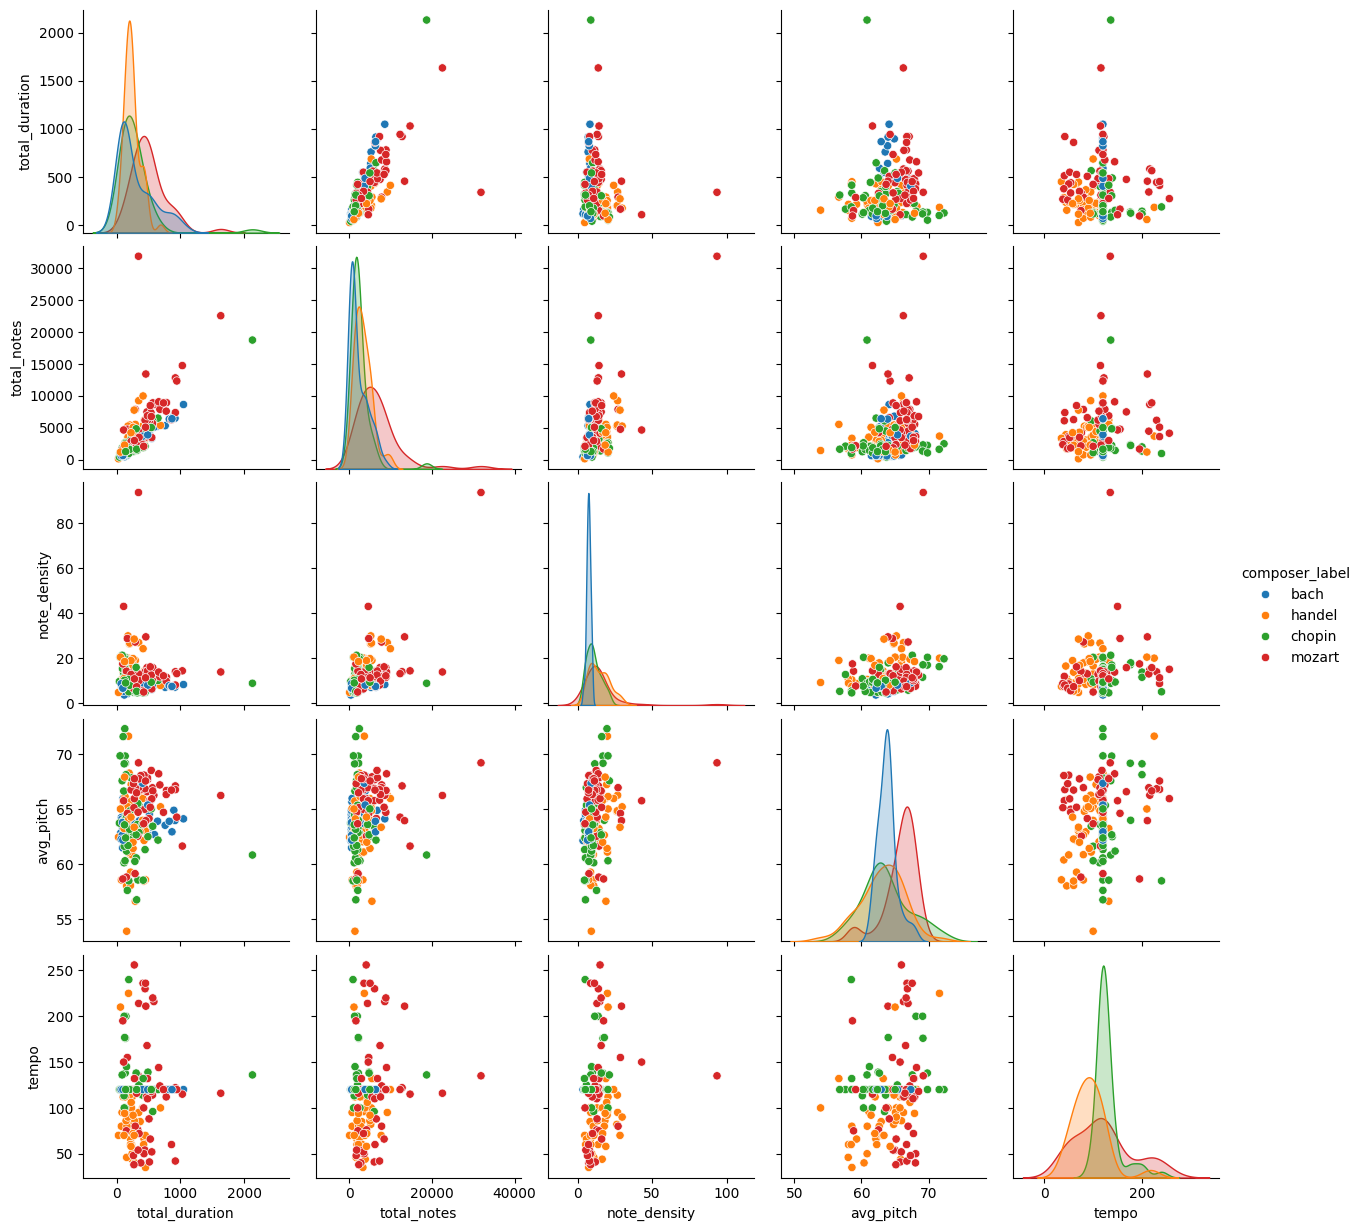

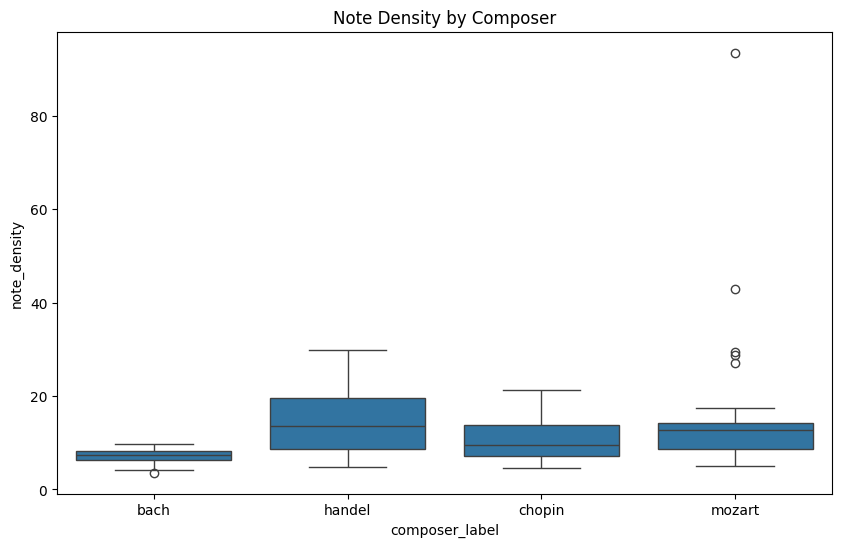

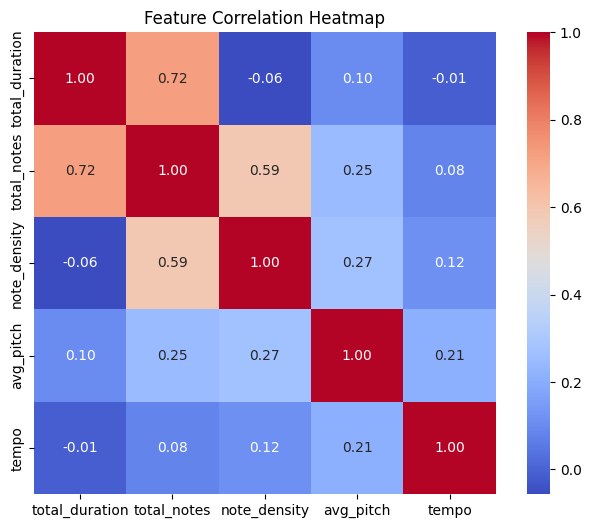

In [21]:
run_exploratory_data_analysis(all_features_df)

In [22]:
#What is the counts of data in each folder, train, test, validation?
print(train_df.shape)
print(validation_df.shape)
print(test_df.shape)

(165, 3)
(16, 3)
(16, 3)


#Model Building

###LSTM

In [23]:
def create_lstm_input_sequences(input_df, sequence_column='note_seq', target_length=500):
    """
    Prepares input sequences and corresponding labels for LSTM training using note sequence data.

    This function converts variable-length MIDI note sequences into fixed-length padded sequences,
    making them compatible with LSTM-based deep learning models for composer classification.
    """

    # Initialize a list to store LSTM input sequences (padded/truncated note sequences).
    X_seq_data = []

    # Initialize a list to store label indices corresponding to composers.
    y_labels_seq = []

    # Create a mapping of composer names to numeric indices for classification.
    # Example: {'Bach': 0,'Chopin': 1, etc.}
    composer_idx_mapping = {name: idx for idx, name in enumerate(composers)}

    # Iterate over each MIDI file (row) in the input dataframe.
    for _, row in input_df.iterrows():

        # Extract the note sequence matrix from the specified column.
        # Each sequence has shape (N, 4), where N is the number of notes, and 4 represents:
        # [start_time, pitch, duration, velocity]
        note_sequence = row[sequence_column]

        # Handle variable sequence lengths by padding or truncating to `target_length`.
        # LSTM models require input sequences to have uniform length.
        if note_sequence.shape[0] < target_length:
            # If the sequence is too short, pad with zeros at the end.
            # Padding preserves sequence order while ensuring shape compatibility.
            padded_sequence = np.pad(note_sequence, ((0, target_length - note_sequence.shape[0]), (0, 0)))
        else:
            # If the sequence is too long, truncate to the first `target_length` steps.
            padded_sequence = note_sequence[:target_length]

        # Append the processed sequence to the input data list.
        X_seq_data.append(padded_sequence)

        # Append the corresponding composer label (as an integer index) to the label list.
        y_labels_seq.append(composer_idx_mapping[row['composer_label']])

    # Convert the list of input sequences into a NumPy array.
    # Final shape: (number_of_samples, target_length, 4)
    X_seq_data = np.array(X_seq_data)

    # Convert labels into one-hot encoded format for classification.
    # Example: If there are 4 classes, label '1' becomes [0,1,0,0]
    y_labels_seq_onehot = to_categorical(y_labels_seq, num_classes=len(composers))

    # Return the LSTM input data (X) and the one-hot encoded labels (y).
    return X_seq_data, y_labels_seq_onehot

In [24]:

def build_simple_lstm_classifier(input_dimensions, num_output_classes):
    """
    Builds and returns a simple LSTM-based neural network classifier for sequence data.

    This model is used to classify composers based on note sequence data extracted from MIDI files.
    LSTMs are ideal for this task because they can capture temporal dependencies in sequential musical patterns.
    """

    # Initialize a Keras Sequential model.
    # This means the layers are stacked one after the other in a linear pipeline.
    lstm_net = models.Sequential()

    # Add an input layer to define the shape of the input sequences.
    # input_dimensions: (sequence_length, number_of_features) -> (500, 4) in this project.
    # Features include: start_time, pitch, duration, velocity.
    lstm_net.add(layers.Input(shape=input_dimensions))

    # Add a Long Short-Term Memory (LSTM) layer with 64 units.
    # LSTM layers are designed to learn temporal patterns in sequence data.
    # Here, it learns how note sequences vary across different composers.
    lstm_net.add(layers.LSTM(64))

    # Add a fully connected Dense layer with 64 neurons and ReLU activation.
    # This layer introduces non-linearity and helps the model learn complex decision boundaries
    # after processing the sequential data from the LSTM.
    lstm_net.add(layers.Dense(64, activation='relu'))

    # Add the output Dense layer with 'num_output_classes' neurons (e.g., 4 composers).
    # Use softmax activation to output class probabilities (multi-class classification).
    lstm_net.add(layers.Dense(num_output_classes, activation='softmax'))

    # Compile the model:
    # - Optimizer: Adam (adaptive learning rate, good for deep learning tasks)
    # - Loss function: Categorical cross-entropy (because labels are one-hot encoded)
    # - Metrics: Track accuracy during training and evaluation.
    lstm_net.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Return the constructed LSTM classifier model.
    return lstm_net

###CNN

In [28]:
def create_cnn_ready_data(input_df, piano_roll_column='piano_roll', max_length=5000):
    """
    Converts piano roll matrices into CNN-ready image tensors.

    Piano rolls are treated as 2D images where height = 128 MIDI pitches and width = time steps.
    This function formats the data for CNN input by resizing, padding, and adding a channel dimension.
    """

    # Initialize a list to hold the CNN input images (piano rolls as tensors).
    X_cnn_inputs = []

    # Initialize a list to hold the corresponding composer labels as class indices.
    y_cnn_labels = []

    # Create a mapping of composer names to numeric indices.
    # Example: {'Bach': 0, 'Beethoven': 1, 'Chopin': 2, 'Mozart': 3}
    composer_mapping = {name: idx for idx, name in enumerate(COMPOSERS)}

    # Iterate over each row in the input dataframe.
    for _, row in input_df.iterrows():

        # Extract the piano roll matrix from the specified column.
        # Shape: (128, time_steps)
        piano_roll = row[piano_roll_column]

        # Pad the piano roll if it has fewer time steps than max_length.
        # Padding ensures all inputs have the same width (time dimension).
        if piano_roll.shape[1] < max_length:
            piano_roll_padded = np.pad(piano_roll, ((0, 0), (0, max_length - piano_roll.shape[1])))
        else:
            # If the piano roll is longer, truncate it to max_length time steps.
            piano_roll_padded = piano_roll[:, :max_length]

        # Add a channel dimension to match CNN input format: (128, max_length, 1).
        # This makes the piano roll a grayscale "image" for the CNN.
        X_cnn_inputs.append(piano_roll_padded[..., np.newaxis])

        # Append the corresponding composer label as a numeric index.
        y_cnn_labels.append(composer_mapping[row['composer_label']])

    # Convert the input list to a NumPy array for CNN training.
    # - Cast to float32 for compatibility with TensorFlow.
    # - Shape: (num_samples, 128, max_length, 1)
    X_cnn_inputs = np.array(X_cnn_inputs).astype(np.float32)

    # One-hot encode the labels for multi-class classification.
    # Shape: (num_samples, num_classes)
    y_cnn_labels = to_categorical(y_cnn_labels, num_classes=len(COMPOSERS))

    # Return the CNN-ready inputs and labels.
    return X_cnn_inputs, y_cnn_labels

In [29]:
def build_simple_cnn_for_pianoroll(cnn_input_shape, num_output_classes):
    """
    Builds and returns a simple Convolutional Neural Network (CNN) classifier for piano roll data.

    This model is used to classify composers based on piano roll "image" features extracted from MIDI files.
    CNNs are well-suited for this task because piano rolls are structured as 2D matrices (128 pitches × time frames),
    making them similar to grayscale images where convolutional layers excel.
    """

    # Initialize a Sequential model from Keras.
    # Sequential models are easy to build layer-by-layer when the architecture is straightforward.
    cnn_net = models.Sequential()

    # Add the first 2D convolutional layer:
    # - 32 filters (feature maps) to detect local pitch-time patterns.
    # - Kernel size of (3,3) allows the network to scan small note-time regions.
    # - Activation function: ReLU (introduces non-linearity).
    # - Input shape: (128, sequence_length, 1) where sequence_length is typically 5000.
    cnn_net.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=cnn_input_shape))

    # Add max pooling layer:
    # - Reduces the spatial dimensions by taking the max value in a (2x2) window.
    # - Helps downsample the input while retaining important features.
    # - Reduces computation and prevents overfitting.
    cnn_net.add(layers.MaxPooling2D((2, 2)))

    # Add a second 2D convolutional layer:
    # - 64 filters to capture more complex and abstract musical patterns.
    # - Larger depth allows the network to learn richer representations.
    cnn_net.add(layers.Conv2D(64, (3, 3), activation='relu'))

    # Add another max pooling layer:
    # - Further reduces spatial size to make the model more efficient.
    # - Also helps extract hierarchical features (small patterns → larger patterns).
    cnn_net.add(layers.MaxPooling2D((2, 2)))

    # Flatten the multi-dimensional output of the convolutional layers.
    # - Converts 2D feature maps into a 1D vector to feed into fully connected layers.
    cnn_net.add(layers.Flatten())

    # Add a dense (fully connected) hidden layer:
    # - 128 neurons to combine features learned by the CNN layers.
    # - ReLU activation helps capture non-linear relationships between features.
    cnn_net.add(layers.Dense(128, activation='relu'))

    # Add the final output layer:
    # - Number of neurons equals the number of output classes (e.g., 4 composers).
    # - Softmax activation produces probabilities for multi-class classification.
    cnn_net.add(layers.Dense(num_output_classes, activation='softmax'))

    # Compile the CNN model:
    # - Optimizer: Adam (adaptive learning rate, efficient for deep learning tasks).
    # - Loss function: Categorical cross-entropy (for multi-class classification with one-hot labels).
    # - Metric: Accuracy (to track performance during training and validation).
    cnn_net.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Return the constructed CNN model.
    return cnn_net

##Model Training & Evaluation

In [26]:
# -----------------------------
# LSTM Model (Sequence Model)
# -----------------------------
print(" Preparing LSTM data...")

# Prepares sequence data for LSTM by extracting fixed-length note sequences.
# Sequences are padded or truncated to uniform length (500 steps here).
X_train_lstm, y_train_lstm = create_lstm_input_sequences(train_features, target_length=500)
X_test_lstm, y_test_lstm = create_lstm_input_sequences(test_features, target_length=500)

print(" Training LSTM model...")

# Define input shape for the LSTM model: (sequence_length, feature_dim), e.g., (500, 4)
input_shape_lstm = (X_train_lstm.shape[1], X_train_lstm.shape[2])

# Build an LSTM-based neural network for composer classification.
lstm_model_final = build_simple_lstm_classifier(input_shape_lstm, num_output_classes=len(composers))

# Train the LSTM model
history = lstm_model_final.fit(
    X_train_lstm, y_train_lstm,
    epochs=100,
    batch_size=16,
    validation_split=0.2,  # or use validation_data=(X_val, y_val)
    verbose=1
)

 Preparing LSTM data...
 Training LSTM model...
Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 213ms/step - accuracy: 0.3134 - loss: 1.4385 - val_accuracy: 0.0000e+00 - val_loss: 1.7305
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 358ms/step - accuracy: 0.6222 - loss: 1.0644 - val_accuracy: 0.0000e+00 - val_loss: 1.9724
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 392ms/step - accuracy: 0.8109 - loss: 0.8711 - val_accuracy: 0.0000e+00 - val_loss: 2.0494
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 425ms/step - accuracy: 0.8129 - loss: 0.6915 - val_accuracy: 0.0000e+00 - val_loss: 2.3313
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step - accuracy: 0.8140 - loss: 0.6384 - val_accuracy: 0.0000e+00 - val_loss: 2.4044
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 265ms/step - accuracy: 0.8515 - loss: 0.5003 - val_accuracy: 0.0000e+00 - val_loss: 2.6244
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 388ms/step - accuracy: 0.9097 - loss: 0.3800 - val_accuracy: 0.0000e+00 - val_loss: 2.5496
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━

In [27]:
# Evaluate on test set using Keras
loss, accuracy = lstm_model_final.evaluate(X_test_lstm, y_test_lstm, verbose=1)

print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.6875 - loss: 1.0572

Test Loss: 1.0572
Test Accuracy: 0.6875


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
              precision    recall  f1-score   support

        bach       1.00      1.00      1.00         4
      handel       0.50      0.75      0.60         4
      chopin       0.67      1.00      0.80         4
      mozart       0.00      0.00      0.00         4

    accuracy                           0.69        16
   macro avg       0.54      0.69      0.60        16
weighted avg       0.54      0.69      0.60        16



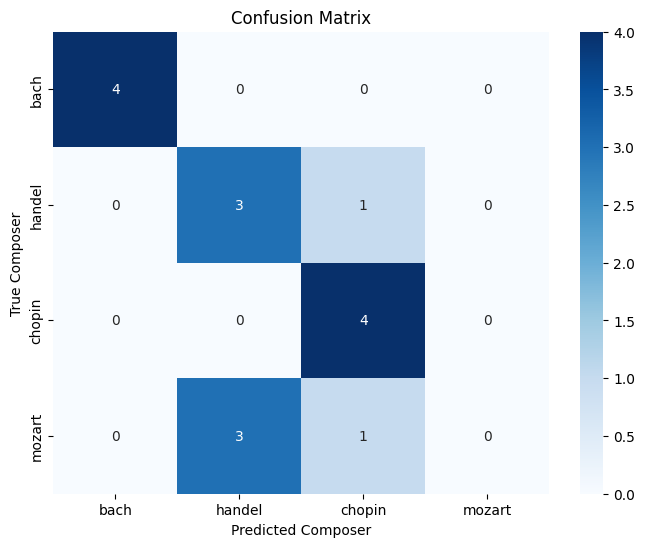

In [28]:
# Composer names/classes, in label order
class_names = ['bach', 'handel', 'chopin', 'mozart']  # Adapt as needed

# Evaluate the model and predict classes
# y_test: true labels (one-hot encoded or integer-encoded)
# model: your trained LSTM

# Get predicted probabilities
y_pred_proba = lstm_model_final.predict(X_test_lstm)

# Convert probabilities to predicted class indices
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_test_lstm, axis=1)  # if y_test is one-hot; else use y_test directly

# Print classification report with composer names
print(classification_report(y_true, y_pred, target_names=class_names))

# Build and plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Composer')
plt.ylabel('True Composer')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# -----------------------------
#  CNN on Piano Roll
# -----------------------------
print(" Preparing CNN data from piano rolls...")

# Prepares CNN input data by converting piano roll matrices to (128, sequence_length, 1).
# Each piano roll is treated as a grayscale image for CNN learning.
X_train_cnn, y_train_cnn = create_cnn_ready_data(train_features, max_length=5000)
X_test_cnn, y_test_cnn = create_cnn_ready_data(test_features, max_length=5000)

print(" Training CNN on Piano Roll...")

# Define CNN input shape: (128, sequence_length, 1)
cnn_input_shape = X_train_cnn.shape[1:]

# Build CNN model to classify composer from piano roll images.
cnn_model_final = build_simple_cnn_for_pianoroll(cnn_input_shape, num_output_classes=len(composers))

# Evaluate CNN model
train_and_report_deep_model(cnn_model_final, X_train_cnn, y_train_cnn, X_test_cnn, y_test_cnn)

 Preparing CNN data from piano rolls...
 Training CNN on Piano Roll...


#Model Optimization

Techniques for optimization:

1. Data Handling
2. Hyperparameter Tuning
3.

In [29]:
'''

def create_tabular_features_and_labels(input_df):
    """
    Prepares tabular feature data and label encoding for classical machine learning models.

    This function selects numerical/statistical features from the MIDI data and encodes the composer labels
    into numerical classes. The output is designed for use in RandomForest and XGBoost classifiers,
    which require tabular input data.
    """

    # Select relevant numerical features from the input DataFrame for model input.
    # These features represent high-level statistical information about each MIDI file.
    # Features selected:
    # - total_duration: Overall length of the piece in seconds.
    # - total_notes: Total number of notes in the composition.
    # - note_density: Notes per second, indicating playing speed or complexity.
    # - avg_pitch: The average pitch used, reflecting the register of the composition.
    # - tempo: The BPM (beats per minute) of the composition.
    X_features = input_df[['total_duration', 'total_notes', 'note_density', 'avg_pitch', 'tempo']]

    # Extract the composer labels (string values) to be used as targets for classification.
    # For example: "Bach", "Beethoven", "Chopin", "Mozart"
    y_labels = input_df['composer_label']

    # Initialize a LabelEncoder to convert composer names into numeric labels.
    # Machine learning models cannot process string labels directly.
    label_encoder = LabelEncoder()

    # Fit the label encoder to the composer labels and transform them into integer values.
    # Example mapping: Bach -> 0, Beethoven -> 1, Chopin -> 2, Mozart -> 3
    y_encoded_labels = label_encoder.fit_transform(y_labels)

    # Return:
    # - X_features: The feature matrix for model input (numpy or pandas format).
    # - y_encoded_labels: The numerical labels corresponding to composers.
    # - label_encoder: The fitted encoder to allow inverse transform during predictions.
    return X_features, y_encoded_labels, label_encoder

In [ ]:
'''
def train_and_report_deep_model(neural_model, X_train_data, y_train_data, X_test_data, y_test_data, num_epochs=20, batch_sz=32):
    """
    Trains a deep learning model (LSTM or CNN) and prints evaluation metrics for classification.

    This function handles both training and evaluation of sequence-based (LSTM) and image-based (CNN) models
    used for music composer classification.
    """

    # Train the deep learning model using the training data.
    # Uses early stopping on validation split internally (by monitoring validation performance manually if needed later).
    # validation_split=0.2 means 20% of training data is reserved for validation.
    # verbose=0 disables intermediate output to keep logs clean.
    neural_model.fit(X_train_data, y_train_data,
                     epochs=num_epochs,
                     batch_size=batch_sz,
                     validation_split=0.2,
                     verbose=0)

    # Use the trained model to predict class probabilities on the test dataset.
    # Each prediction is a probability vector (one per composer).
    y_predictions = neural_model.predict(X_test_data)

    # Convert the one-hot encoded true labels back to integer indices.
    # For example: [0,1,0,0] → 1 (if there are 4 classes).
    y_true_labels = np.argmax(y_test_data, axis=1)

    # Convert the predicted probability vectors into predicted class labels.
    # For example: [0.1, 0.7, 0.1, 0.1] → 1
    y_pred_labels = np.argmax(y_predictions, axis=1)

    # Print a detailed classification report.
    # Includes precision, recall, F1-score, and support for each composer.
    # Uses COMPOSERS as the class label names for human-readable output.
    print(classification_report(y_true_labels, y_pred_labels, target_names=COMPOSERS))

    # Print the confusion matrix to show how often each composer was confused with another.
    # Useful for understanding specific model weaknesses (e.g., Bach vs. Mozart confusion).
    print("Confusion Matrix:\n", confusion_matrix(y_true_labels, y_pred_labels))